![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/10.Clinical_Relation_Extraction.ipynb)

## 10. Clinical Relation Extraction Model

In [2]:
import os

jsl_secret = os.getenv('SECRET')

import sparknlp
sparknlp_version = sparknlp.version()
import sparknlp_jsl
jsl_version = sparknlp_jsl.version()

print (jsl_secret)

In [3]:
import json
import os
import sparknlp
import sparknlp_jsl
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *


params = {"spark.driver.memory":"16G",
"spark.kryoserializer.buffer.max":"2000M",
"spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(jsl_secret, params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

Spark NLP Version : 3.1.2
Spark NLP_JSL Version : 3.1.2


## Posology Releation Extraction

This is a demonstration of using SparkNLP for extracting posology relations. The following relatios are supported:

DRUG-DOSAGE
DRUG-FREQUENCY
DRUG-ADE (Adversed Drug Events)
DRUG-FORM
DRUG-ROUTE
DRUG-DURATION
DRUG-REASON
DRUG=STRENGTH

The model has been validated against the posology dataset described in (Magge, Scotch, & Gonzalez-Hernandez, 2018).

| Relation | Recall | Precision | F1 | F1 (Magge, Scotch, & Gonzalez-Hernandez, 2018) |
| --- | --- | --- | --- | --- |
| DRUG-ADE | 0.66 | 1.00 | **0.80** | 0.76 |
| DRUG-DOSAGE | 0.89 | 1.00 | **0.94** | 0.91 |
| DRUG-DURATION | 0.75 | 1.00 | **0.85** | 0.92 |
| DRUG-FORM | 0.88 | 1.00 | **0.94** | 0.95* |
| DRUG-FREQUENCY | 0.79 | 1.00 | **0.88** | 0.90 |
| DRUG-REASON | 0.60 | 1.00 | **0.75** | 0.70 |
| DRUG-ROUTE | 0.79 | 1.00 | **0.88** | 0.95* |
| DRUG-STRENGTH | 0.95 | 1.00 | **0.98** | 0.97 |


*Magge, Scotch, Gonzalez-Hernandez (2018) collapsed DRUG-FORM and DRUG-ROUTE into a single relation.

In [4]:
import functools 
import numpy as np
from scipy import spatial
import pyspark.sql.functions as F
import pyspark.sql.types as T
from sparknlp.base import *

**Build pipeline using SparNLP pretrained models and the relation extration model optimized for posology**.
 
 The precision of the RE model is controlled by "setMaxSyntacticDistance(4)", which sets the maximum syntactic distance between named entities to 4. A larger value will improve recall at the expense at lower precision. A value of 4 leads to literally perfect precision (i.e. the model doesn't produce any false positives) and reasonably good recall.

In [5]:
documenter = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencer = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentences")

tokenizer = sparknlp.annotators.Tokenizer()\
    .setInputCols(["sentences"])\
    .setOutputCol("tokens")

words_embedder = WordEmbeddingsModel()\
    .pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("embeddings")

pos_tagger = PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("pos_tags")

ner_tagger = MedicalNerModel()\
    .pretrained("ner_posology", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

ner_chunker = NerConverterInternal()\
    .setInputCols(["sentences", "tokens", "ner_tags"])\
    .setOutputCol("ner_chunks")

dependency_parser = DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentences", "pos_tags", "tokens"])\
    .setOutputCol("dependencies")

reModel = RelationExtractionModel()\
    .pretrained("posology_re")\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    ner_tagger,
    ner_chunker,
    dependency_parser,
    reModel
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)


embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]


**Create a light pipeline for annotating free text**

In [6]:
text = """
The patient was prescribed 1 unit of Advil for 5 days after meals. The patient was also 
given 1 unit of Metformin daily.
He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 
12 units of insulin lispro with meals , and metformin 1000 mg two times a day.
"""

lmodel = LightPipeline(model)

results = lmodel.fullAnnotate(text)

In [7]:
results[0].keys()

dict_keys(['sentences', 'document', 'ner_chunks', 'ner_tags', 'relations', 'tokens', 'embeddings', 'pos_tags', 'dependencies'])

In [8]:
results[0]['ner_chunks']

[Annotation(chunk, 28, 33, 1 unit, {'entity': 'DOSAGE', 'sentence': '0', 'chunk': '0', 'confidence': '0.71675'}),
 Annotation(chunk, 38, 42, Advil, {'entity': 'DRUG', 'sentence': '0', 'chunk': '1', 'confidence': '0.9984'}),
 Annotation(chunk, 44, 53, for 5 days, {'entity': 'DURATION', 'sentence': '0', 'chunk': '2', 'confidence': '0.7455'}),
 Annotation(chunk, 96, 101, 1 unit, {'entity': 'DOSAGE', 'sentence': '1', 'chunk': '3', 'confidence': '0.72360003'}),
 Annotation(chunk, 106, 114, Metformin, {'entity': 'DRUG', 'sentence': '1', 'chunk': '4', 'confidence': '0.9998'}),
 Annotation(chunk, 116, 120, daily, {'entity': 'FREQUENCY', 'sentence': '1', 'chunk': '5', 'confidence': '0.9997'}),
 Annotation(chunk, 190, 197, 40 units, {'entity': 'DOSAGE', 'sentence': '2', 'chunk': '6', 'confidence': '0.84085'}),
 Annotation(chunk, 202, 217, insulin glargine, {'entity': 'DRUG', 'sentence': '2', 'chunk': '7', 'confidence': '0.87525'}),
 Annotation(chunk, 219, 226, at night, {'entity': 'FREQUENCY', '

In [9]:
results[0]['relations']

[Annotation(category, 28, 42, DOSAGE-DRUG, {'chunk2': 'Advil', 'confidence': '1.0', 'entity2_end': '42', 'chunk1': '1 unit', 'entity2_begin': '38', 'entity1': 'DOSAGE', 'entity1_begin': '28', 'entity1_end': '33', 'entity2': 'DRUG'}),
 Annotation(category, 38, 53, DRUG-DURATION, {'chunk2': 'for 5 days', 'confidence': '1.0', 'entity2_end': '53', 'chunk1': 'Advil', 'entity2_begin': '44', 'entity1': 'DRUG', 'entity1_begin': '38', 'entity1_end': '42', 'entity2': 'DURATION'}),
 Annotation(category, 96, 114, DOSAGE-DRUG, {'chunk2': 'Metformin', 'confidence': '1.0', 'entity2_end': '114', 'chunk1': '1 unit', 'entity2_begin': '106', 'entity1': 'DOSAGE', 'entity1_begin': '96', 'entity1_end': '101', 'entity2': 'DRUG'}),
 Annotation(category, 106, 120, DRUG-FREQUENCY, {'chunk2': 'daily', 'confidence': '1.0', 'entity2_end': '120', 'chunk1': 'Metformin', 'entity2_begin': '116', 'entity1': 'DRUG', 'entity1_begin': '106', 'entity1_end': '114', 'entity2': 'FREQUENCY'}),
 Annotation(category, 190, 217, D

**Show extracted relations**

In [9]:
for rel in results[0]["relations"]:
    print("{}({}={} - {}={})".format(
        rel.result, 
        rel.metadata['entity1'], 
        rel.metadata['chunk1'], 
        rel.metadata['entity2'],
        rel.metadata['chunk2']
    ))

DOSAGE-DRUG(DOSAGE=1 unit - DRUG=Advil)
DRUG-DURATION(DRUG=Advil - DURATION=for 5 days)
DOSAGE-DRUG(DOSAGE=1 unit - DRUG=Metformin)
DRUG-FREQUENCY(DRUG=Metformin - FREQUENCY=daily)
DOSAGE-DRUG(DOSAGE=40 units - DRUG=insulin glargine)
DRUG-FREQUENCY(DRUG=insulin glargine - FREQUENCY=at night)
DOSAGE-DRUG(DOSAGE=12 units - DRUG=insulin lispro)
DRUG-FREQUENCY(DRUG=insulin lispro - FREQUENCY=with meals)
DRUG-STRENGTH(DRUG=metformin - STRENGTH=1000 mg)
DRUG-FREQUENCY(DRUG=metformin - FREQUENCY=two times a day)


In [10]:
import pandas as pd

def get_relations_df (results, col='relations'):
  rel_pairs=[]
  for rel in results[0][col]:
      rel_pairs.append((
          rel.result, 
          rel.metadata['entity1'], 
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'], 
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'], 
          rel.metadata['confidence']
      ))

  rel_df = pd.DataFrame(rel_pairs, columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])

  return rel_df


rel_df = get_relations_df (results)

rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,DOSAGE-DRUG,DOSAGE,28,33,1 unit,DRUG,38,42,Advil,1.0
1,DRUG-DURATION,DRUG,38,42,Advil,DURATION,44,53,for 5 days,1.0
2,DOSAGE-DRUG,DOSAGE,96,101,1 unit,DRUG,106,114,Metformin,1.0
3,DRUG-FREQUENCY,DRUG,106,114,Metformin,FREQUENCY,116,120,daily,1.0
4,DOSAGE-DRUG,DOSAGE,190,197,40 units,DRUG,202,217,insulin glargine,1.0
5,DRUG-FREQUENCY,DRUG,202,217,insulin glargine,FREQUENCY,219,226,at night,1.0
6,DOSAGE-DRUG,DOSAGE,231,238,12 units,DRUG,243,256,insulin lispro,1.0
7,DRUG-FREQUENCY,DRUG,243,256,insulin lispro,FREQUENCY,258,267,with meals,1.0
8,DRUG-STRENGTH,DRUG,275,283,metformin,STRENGTH,285,291,1000 mg,1.0
9,DRUG-FREQUENCY,DRUG,275,283,metformin,FREQUENCY,293,307,two times a day,1.0


In [12]:
text ="""A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), 
one prior episode of HTG-induced pancreatitis three years prior to presentation,  associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely . 
She had close follow-up with endocrinology post discharge .
"""

annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df



,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,DURATION-DRUG,DURATION,493,500,five-day,DRUG,512,522,amoxicillin,1.0
1,DRUG-DURATION,DRUG,681,693,dapagliflozin,DURATION,695,708,for six months,1.0
2,DRUG-ROUTE,DRUG,1940,1946,insulin,ROUTE,1948,1951,drip,1.0
3,DOSAGE-DRUG,DOSAGE,2255,2262,40 units,DRUG,2267,2282,insulin glargine,1.0
4,DRUG-FREQUENCY,DRUG,2267,2282,insulin glargine,FREQUENCY,2284,2291,at night,1.0
5,DOSAGE-DRUG,DOSAGE,2295,2302,12 units,DRUG,2307,2320,insulin lispro,1.0
6,DRUG-FREQUENCY,DRUG,2307,2320,insulin lispro,FREQUENCY,2322,2331,with meals,1.0
7,DRUG-STRENGTH,DRUG,2339,2347,metformin,STRENGTH,2349,2355,1000 mg,1.0
8,DRUG-FREQUENCY,DRUG,2339,2347,metformin,FREQUENCY,2357,2371,two times a day,1.0


**Visualization of Extracted Relations**

In [13]:
text = """
The patient was prescribed 1 unit of Advil for 5 days after meals. The patient was also 
given 1 unit of Metformin daily.
He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine , 
12 units of insulin lispro with meals , and metformin two times a day.
"""

lmodel = LightPipeline(model)

results = lmodel.fullAnnotate(text)

In [14]:
from sparknlp_display import RelationExtractionVisualizer


vis = RelationExtractionVisualizer()
vis.display(results[0], 'relations', show_relations=True) # default show_relations: True


/usr/local/lib/python3.7/dist-packages/sparknlp_display/relation_extraction.py:366: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  relation_coordinates = np.array(relation_coordinates)


## ADE Relation Extraction

We can extract relations between `DRUG` and adverse reactions `ADE` caused by them. Also we can find if an adverse event is caused by a drug or not.

`1`: Shows the adverse event and drug entities are related.

`0`: Shows the adverse event and drug entities are not related.

Now we will first use `ner_ade_clinical` NER model and detect `DRUG` and `ADE` entities. Then we ca find the relations between them by using `re_ade_clinical` model. We can also use the same pipeline elemnets rest of them we created above.

In [25]:
ner_tagger = MedicalNerModel.pretrained("ner_ade_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")  

reModel = RelationExtractionModel()\
    .pretrained("re_ade_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(10)\
    .setRelationPairs(["drug-ade, ade-drug"])

ade_pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    ner_tagger,
    ner_chunker,
    dependency_parser,
    reModel
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_model = ade_pipeline.fit(empty_data)

ner_ade_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
re_ade_clinical download started this may take some time.
Approximate size to download 10.9 MB
[OK!]


We will create a LightPipeline for annotation.

In [26]:
ade_lmodel = LightPipeline(ade_model)

In [27]:
text ="""A 44-year-old man taking naproxen for chronic low back pain and a 20-year-old woman on oxaprozin for rheumatoid arthritis presented with tense bullae and cutaneous fragility on the face and the back of the hands."""

ade_results = ade_lmodel.fullAnnotate(text)

In [28]:
ade_results[0].keys()

dict_keys(['sentences', 'document', 'ner_chunks', 'ner_tags', 'relations', 'tokens', 'embeddings', 'pos_tags', 'dependencies'])

In [29]:
ade_results[0]["ner_chunks"]

[Annotation(chunk, 25, 32, naproxen, {'entity': 'DRUG', 'sentence': '0', 'chunk': '0', 'confidence': '0.996'}),
 Annotation(chunk, 87, 95, oxaprozin, {'entity': 'DRUG', 'sentence': '0', 'chunk': '1', 'confidence': '0.9749'}),
 Annotation(chunk, 137, 148, tense bullae, {'entity': 'ADE', 'sentence': '0', 'chunk': '2', 'confidence': '0.77250004'}),
 Annotation(chunk, 154, 210, cutaneous fragility on the face and the back of the hands, {'entity': 'ADE', 'sentence': '0', 'chunk': '3', 'confidence': '0.7458182'})]

**Lets show the `ADE`-`DRUG` relations by using pandas dataframe.**

In [30]:
print(text)

rel_df = get_relations_df (ade_results)

rel_df


A 44-year-old man taking naproxen for chronic low back pain and a 20-year-old woman on oxaprozin for rheumatoid arthritis presented with tense bullae and cutaneous fragility on the face and the back of the hands.


,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,1,DRUG,25,32,naproxen,ADE,137,148,tense bullae,1.0
1,1,DRUG,25,32,naproxen,ADE,154,210,cutaneous fragility on the face and the back o...,0.99999964
2,1,DRUG,87,95,oxaprozin,ADE,137,148,tense bullae,1.0
3,1,DRUG,87,95,oxaprozin,ADE,154,210,cutaneous fragility on the face and the back o...,1.0


In [31]:
text = "I experienced fatigue, muscle cramps, anxiety, agression and sadness after taking Lipitor but no more adverse after passing Zocor."

ade_results = ade_lmodel.fullAnnotate(text)

rel_df = get_relations_df (ade_results)

rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,1,ADE,14,20,fatigue,DRUG,82,88,Lipitor,0.9996617
1,0,ADE,14,20,fatigue,DRUG,124,128,Zocor,0.9952187
2,1,ADE,23,35,muscle cramps,DRUG,82,88,Lipitor,0.9999827
3,0,ADE,23,35,muscle cramps,DRUG,124,128,Zocor,0.91462934
4,1,ADE,38,44,anxiety,DRUG,82,88,Lipitor,0.7636133
5,0,ADE,38,44,anxiety,DRUG,124,128,Zocor,0.9999691
6,1,ADE,47,55,agression,DRUG,82,88,Lipitor,0.99999833
7,0,ADE,47,55,agression,DRUG,124,128,Zocor,0.99781835
8,1,ADE,61,67,sadness,DRUG,82,88,Lipitor,1.0
9,0,ADE,61,67,sadness,DRUG,124,128,Zocor,0.9999572


**Visualization of relations**

In [34]:
vis = RelationExtractionVisualizer()

vis.display(ade_results[0], 'relations', show_relations=True)


/usr/local/lib/python3.7/dist-packages/sparknlp_display/relation_extraction.py:366: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  relation_coordinates = np.array(relation_coordinates)


## Clinical RE

**The set of relations defined in the 2010 i2b2 relation challenge**

TrIP: A certain treatment has improved or cured a medical problem (eg, ‘infection resolved with antibiotic course’)

TrWP: A patient's medical problem has deteriorated or worsened because of or in spite of a treatment being administered (eg, ‘the tumor was growing despite the drain’)

TrCP: A treatment caused a medical problem (eg, ‘penicillin causes a rash’)

TrAP: A treatment administered for a medical problem (eg, ‘Dexamphetamine for narcolepsy’)

TrNAP: The administration of a treatment was avoided because of a medical problem (eg, ‘Ralafen which is contra-indicated because of ulcers’)

TeRP: A test has revealed some medical problem (eg, ‘an echocardiogram revealed a pericardial effusion’)

TeCP: A test was performed to investigate a medical problem (eg, ‘chest x-ray done to rule out pneumonia’)

PIP: Two problems are related to each other (eg, ‘Azotemia presumed secondary to sepsis’)

In [23]:
clinical_ner_tagger = MedicalNerModel()\
    .pretrained("ner_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

clinical_re_Model = RelationExtractionModel()\
    .pretrained("re_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\
    .setRelationPairs(["problem-test", "problem-treatment"]) # we can set the possible relation pairs (if not set, all the relations will be calculated)

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    clinical_ner_tagger,
    ner_chunker,
    dependency_parser,
    clinical_re_Model
])


empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
re_clinical download started this may take some time.
Approximate size to download 6 MB
[OK!]


In [24]:
text ="""A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), 
one prior episode of HTG-induced pancreatitis three years prior to presentation,  associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely . 
She had close follow-up with endocrinology post discharge .
"""

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df[rel_df.relation!="O"]


,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
11,TrAP,PROBLEM,617,620,T2DM,TREATMENT,626,637,atorvastatin,0.99955326
15,TeRP,TEST,739,758,Physical examination,PROBLEM,796,810,dry oral mucosa,0.9994142
19,TrWP,TEST,1246,1258,blood samples,PROBLEM,1265,1274,hemolyzing,0.9854173
21,TeRP,TEST,1535,1547,the anion gap,PROBLEM,1553,1566,still elevated,0.9965193
26,TrAP,TEST,1838,1845,analysis,PROBLEM,1854,1880,interference from turbidity,0.9676019
33,TrAP,PROBLEM,1967,1969,HTG,TREATMENT,1976,1986,a reduction,0.9875973
34,TrAP,PROBLEM,1967,1969,HTG,TEST,1991,2003,the anion gap,0.9993911


## Clinical Temporal Events RE

Temporal relations, or temporal links (denoted by the TLINK tag), indicate whether and how two EVENTs, two TIME, or an EVENT and a TIME related to each other in the clinical timeline. There are 3 type of relations here and below are some examples of Relations, with square brackets indicating EVENT and TIME connected by a temporal link:

**`BEFORE`**

The patient was given stress dose steroids prior to his surgery. ([stress dose steroids] `BEFORE` [his surgery])

The patient had an undocumented history of possible atrial fibrillation prior to admission. ([possible atrial fibrillation] `BEFORE` [admission])

His nasogastric tube was discontinued on 05-26-98. ([His nasogastric] `BEFORE` [05-26-98])

**`AFTER`**

Before admission, he had another serious concussion. ([admission] `AFTER` [another serious concussion])

On postoperative day No 1, he was started on Percocet. ([Percocet] `AFTER` [postoperative day No 1])


**`OVERLAP`**

She denies any fevers or chills. ([fevers] `OVERLAP` [chills])

The patient's serum creatinine on discharge date, 2012-05-06, was 1.9. ([discharge date] `OVERLAP` [2012-05-06])

His preoperative workup was completed and included a normal white count ([a normal white count] `OVERLAP` [His preoperative workup])

The patient had an undocumented history of possible atrial fibrillation prior to admission. ([possible atrial fibrillation] `OVERLAP` [admission])


| Relation | Recall | Precision | F1 |
| --- | --- | --- | --- |
| OVERLAP | 0.81 | 0.73 | **0.77** |
| BEFORE | 0.85 | 0.88 | **0.86** |
| AFTER | 0.38 | 0.46 | **0.43** |



This RE model works with `ner_events_clinical` NER model and expect the following entities as inputs:

[`OCCURRENCE`,
 `DATE`,
 `DURATION`,
 `EVIDENTIAL`,
 `TEST`,
 `PROBLEM`,
 `TREATMENT`,
 `CLINICAL_DEPT`,
 `FREQUENCY`,
 `TIME`]

In [25]:
events_ner_tagger = MedicalNerModel()\
    .pretrained("ner_events_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

clinical_re_Model = RelationExtractionModel()\
    .pretrained("re_temporal_events_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.9)

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    events_ner_tagger,
    ner_chunker,
    dependency_parser,
    clinical_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

ner_events_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
re_temporal_events_clinical download started this may take some time.
Approximate size to download 5.9 MB
[OK!]


In [26]:
events_ner_tagger.getClasses()

['O',
 'B-OCCURRENCE',
 'B-DATE',
 'B-PROBLEM',
 'I-PROBLEM',
 'B-DURATION',
 'I-DURATION',
 'B-EVIDENTIAL',
 'I-OCCURRENCE',
 'B-TREATMENT',
 'I-TREATMENT',
 'I-DATE',
 'B-TEST',
 'I-TEST',
 'B-CLINICAL_DEPT',
 'I-CLINICAL_DEPT',
 'B-FREQUENCY',
 'I-FREQUENCY',
 'I-EVIDENTIAL',
 'B-TIME',
 'I-TIME']

In [27]:
text ="She is diagnosed as cancer in 1991. Then she was admitted to Mayo Clinic in May 2000 and discharged in October 2001"

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df = rel_df[(rel_df.relation!="O")]

rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,BEFORE,PROBLEM,20,25,cancer,DATE,30,33,1991,0.9989215
1,AFTER,OCCURRENCE,49,56,admitted,CLINICAL_DEPT,61,71,Mayo Clinic,1.0
2,OVERLAP,OCCURRENCE,49,56,admitted,DATE,76,83,May 2000,0.99152386
3,BEFORE,CLINICAL_DEPT,61,71,Mayo Clinic,OCCURRENCE,89,98,discharged,1.0
4,BEFORE,OCCURRENCE,89,98,discharged,DATE,103,114,October 2001,0.95415086


In [28]:
text ="On 9–28-92, the patient will return for chemotherapy and she will follow up with her primary doctor, for PT and Coumadin dosing on Monday."

annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df.confidence = rel_df.confidence.astype(float)

rel_df = rel_df[(rel_df.relation!="O")]

rel_df[(rel_df.relation!="O")&(rel_df.entity1!=rel_df.entity2)]


,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,OVERLAP,DATE,3,9,9–28-92,TREATMENT,40,51,chemotherapy,1.000000
1,OVERLAP,DATE,3,9,9–28-92,TREATMENT,105,106,PT,0.989851
3,OVERLAP,OCCURRENCE,66,74,follow up,CLINICAL_DEPT,81,98,her primary doctor,0.998086
4,OVERLAP,OCCURRENCE,66,74,follow up,TREATMENT,105,106,PT,0.999761
5,OVERLAP,OCCURRENCE,66,74,follow up,TREATMENT,112,126,Coumadin dosing,0.958726
6,OVERLAP,CLINICAL_DEPT,81,98,her primary doctor,TREATMENT,105,106,PT,1.000000
7,OVERLAP,CLINICAL_DEPT,81,98,her primary doctor,DATE,131,136,Monday,0.984193
9,AFTER,TREATMENT,105,106,PT,DATE,131,136,Monday,0.926052
10,OVERLAP,TREATMENT,112,126,Coumadin dosing,DATE,131,136,Monday,0.999999


**Admission-Discharge Events Exraction**

We can also extract `ADMISSION` and `DISCHARGE` entities in addition to `ner_events_clinical` model entities using `ner_events_admission_clinical` NER model and expect the following entities as inputs:
   
[`EVIDENTIAL`,
 `OCCURRENCE`,
 `TREATMENT`,
 `DATE`,
 `ADMISSION`,
 `TIME`,
 `FREQUENCY`,
 `CLINICAL_DEPT`,
 `DURATION`,
 `PROBLEM`,
 `TEST`,
 `DISCHARGE`]

In [29]:
events_admission_ner_tagger = MedicalNerModel()\
    .pretrained("ner_events_admission_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    events_admission_ner_tagger,
    ner_chunker,
    dependency_parser,
    clinical_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

ner_events_admission_clinical download started this may take some time.
Approximate size to download 14.5 MB
[OK!]


In [30]:
events_admission_ner_tagger.getClasses()

['O',
 'B-EVIDENTIAL',
 'I-OCCURRENCE',
 'I-TREATMENT',
 'I-DATE',
 'B-ADMISSION',
 'B-TREATMENT',
 'I-TIME',
 'I-FREQUENCY',
 'B-FREQUENCY',
 'B-OCCURRENCE',
 'I-CLINICAL_DEPT',
 'B-DURATION',
 'I-PROBLEM',
 'I-TEST',
 'B-DATE',
 'B-TIME',
 'I-EVIDENTIAL',
 'I-DURATION',
 'B-DISCHARGE',
 'B-TEST',
 'B-PROBLEM',
 'B-CLINICAL_DEPT']

In [31]:
text ="""She is admitted to The John Hopkins Hospital on Monday with a history of gestational diabetes mellitus diagnosed.  
She was seen by the endocrinology service and she was discharged on 03/02/2018 on 40 units of insulin glargine, 
12 units of insulin lispro, and metformin 1000 mg two times a day. She had close follow-up with endocrinology post discharge. 
"""

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df.confidence = rel_df.confidence.astype(float)

rel_df[(rel_df.relation!="O")]


,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,AFTER,ADMISSION,7,14,admitted,CLINICAL_DEPT,19,43,The John Hopkins Hospital,0.993847
1,OVERLAP,ADMISSION,7,14,admitted,DATE,48,53,Monday,0.991630
2,OVERLAP,CLINICAL_DEPT,19,43,The John Hopkins Hospital,DATE,48,53,Monday,1.000000
3,OVERLAP,DATE,48,53,Monday,PROBLEM,73,101,gestational diabetes mellitus,0.929829
4,OVERLAP,CLINICAL_DEPT,132,156,the endocrinology service,DATE,184,193,03/02/2018,0.999932
5,OVERLAP,DISCHARGE,170,179,discharged,DATE,184,193,03/02/2018,1.000000
6,AFTER,DISCHARGE,170,179,discharged,TREATMENT,210,225,insulin glargine,0.999233
7,AFTER,DISCHARGE,170,179,discharged,TREATMENT,241,254,insulin lispro,0.997469
8,OVERLAP,DATE,184,193,03/02/2018,TREATMENT,210,225,insulin glargine,0.999975
9,OVERLAP,DATE,184,193,03/02/2018,TREATMENT,241,254,insulin lispro,0.999682


**Test-Result-Date Extraction**

There is another Relation Extraction model to link clinical tests to test results and dates to clinical entities: `re_test_result_date`

In [32]:
trd_ner_tagger = MedicalNerModel()\
    .pretrained("jsl_ner_wip_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")       

trd_re_Model = RelationExtractionModel()\
    .pretrained("re_test_result_date", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    trd_ner_tagger,
    ner_chunker,
    dependency_parser,
    trd_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

jsl_ner_wip_clinical download started this may take some time.
Approximate size to download 14.5 MB
[OK!]
re_test_result_date download started this may take some time.
Approximate size to download 9.3 MB
[OK!]


In [33]:
text = 'Hospitalized with pneumonia on 11 June 2019, confirmed by a positive PCR of any specimen, evidenced by SPO2 </= 93%.'

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df.confidence = rel_df.confidence.astype(float)

rel_df[(rel_df.relation!="O")]

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,is_date_of,Disease_Syndrome_Disorder,18,26,pneumonia,Date,31,42,11 June 2019,0.998061
3,is_finding_of,Disease_Syndrome_Disorder,18,26,pneumonia,O2_Saturation,103,114,SPO2 </= 93%,0.984967
6,is_date_of,Date,31,42,11 June 2019,O2_Saturation,103,114,SPO2 </= 93%,0.993791
7,is_result_of,Test_Result,60,67,positive,Test,69,71,PCR,1.000000
8,is_result_of,Test_Result,60,67,positive,O2_Saturation,103,114,SPO2 </= 93%,1.000000


## Human Phenotype - Gene RE

https://github.com/lasigeBioTM/PGR

Human phenotype-gene relations are fundamental to fully understand the origin of some phenotypic abnormalities and their associated diseases. Biomedical literature is the most comprehensive source of these relations, however, we need Relation Extraction tools to automatically recognize them. We present the Phenotype-Gene Relations (PGR) model, trained on a silver standard corpus of human phenotype and gene annotations and their relations. 

It extracts 2 label: `True` or `False`


In [34]:
pgr_ner_tagger = MedicalNerModel()\
    .pretrained("ner_human_phenotype_gene_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

pgr_re_Model = RelationExtractionModel()\
    .pretrained("re_human_phenotype_gene_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setRelationPairs(["hp-gene",'gene-hp'])\
    .setMaxSyntacticDistance(4)\

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    pgr_ner_tagger,
    ner_chunker,
    dependency_parser,
    pgr_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

ner_human_phenotype_gene_clinical download started this may take some time.
Approximate size to download 14 MB
[OK!]
re_human_phenotype_gene_clinical download started this may take some time.
Approximate size to download 5.9 MB
[OK!]


In [35]:
text = "She has a retinal degeneration, hearing loss and renal failure, short stature, \
Mutations in the SH3PXD2B gene coding for the Tks4 protein are responsible for the autosomal recessive."

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df = rel_df[(rel_df.relation!=0)]

rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,1,HP,32,43,hearing loss,GENE,96,103,SH3PXD2B,0.99999976
1,1,HP,49,61,renal failure,GENE,96,103,SH3PXD2B,0.9998969
2,1,HP,64,76,short stature,GENE,96,103,SH3PXD2B,0.99994695


## Drug-Drug Interaction RE

In clinical application, two or more drugs are often used in combination to achieve conducive results, such as synergistic effect, increasing therapeutic effect and reducing or delaying the occurrence of
drug resistance. However, there is a potential for harmful drug-drug
interactions (DDIs) to occur when two or more drugs are taken at the
same time or at certain interval, which can reduce or invalidate the
efficacy of drugs, and increase toxicity or even cause death. Therefore,
in order to prevent harmful drug-drug interaction (DDI), medical staff
often spend much time in reviewing the relevant drug alert literature
and drug knowledge bases. 

**ref**: *Drug-drug interaction extraction via hybrid neural networks on biomedical literature
https://www-sciencedirect-com.ezproxy.leidenuniv.nl:2443/science/article/pii/S1532046420300605*

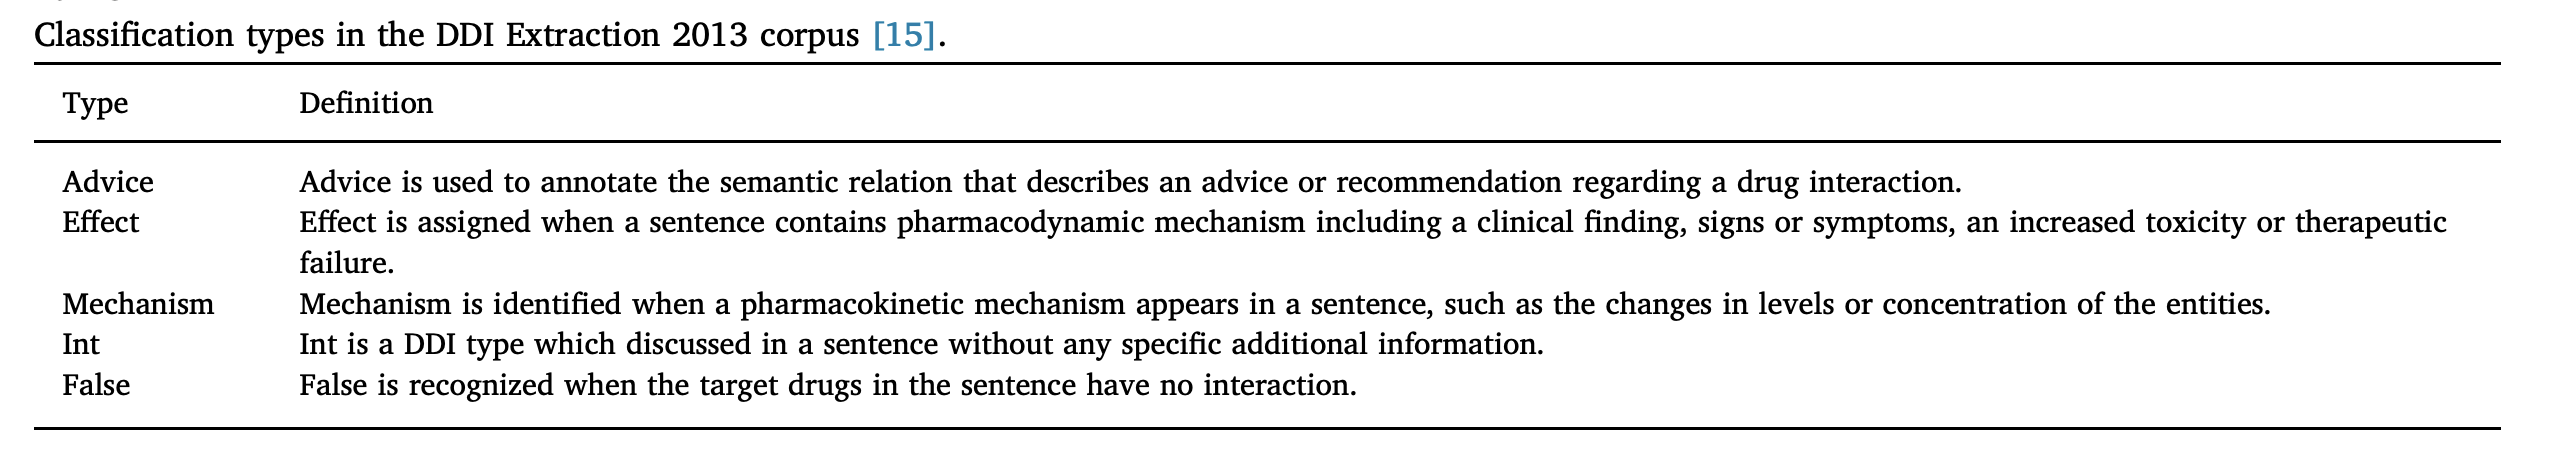

In [36]:
ner_tagger = MedicalNerModel()\
    .pretrained("ner_posology", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")   

ner_converter = NerConverterInternal() \
    .setInputCols(["sentences", "tokens", "ner_tags"]) \
    .setOutputCol("ner_chunk")

ddi_re_model = RelationExtractionModel()\
    .pretrained("re_drug_drug_interaction_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunk", "dependencies"])\
    .setOutputCol("relations")\
    .setRelationPairs(["drug-drug"])\
    .setMaxSyntacticDistance(4)\

ddi_pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    ner_tagger,
    ner_converter,
    dependency_parser,
    ddi_re_model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ddi_model = ddi_pipeline.fit(empty_data)

ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
re_drug_drug_interaction_clinical download started this may take some time.
Approximate size to download 4.6 MB
[OK!]


In [37]:
text='When carbamazepine is withdrawn from the combination therapy, aripiprazole dose should then be reduced. \
If additional adrenergic drugs are to be administered by any route, \
they should be used with caution because the pharmacologically predictable sympathetic effects of Metformin may be potentiated'

lmodel = LightPipeline(ddi_model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)


rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,DDI-advise,DRUG,5,17,carbamazepine,DRUG,62,73,aripiprazole,0.99238014


In [38]:
annotations[0]['ner_chunk']

[Annotation(chunk, 5, 17, carbamazepine, {'entity': 'DRUG', 'sentence': '0', 'chunk': '0', 'confidence': '0.9968'}),
 Annotation(chunk, 62, 73, aripiprazole, {'entity': 'DRUG', 'sentence': '0', 'chunk': '1', 'confidence': '0.9998'}),
 Annotation(chunk, 118, 133, adrenergic drugs, {'entity': 'DRUG', 'sentence': '1', 'chunk': '2', 'confidence': '0.7984'}),
 Annotation(chunk, 270, 278, Metformin, {'entity': 'DRUG', 'sentence': '1', 'chunk': '3', 'confidence': '0.9998'})]

## Chemical–Protein Interactions (ChemProt RE)  

Accurately detecting the interactions between chemicals and proteins is a crucial task that plays a key role in precision medicine, drug discovery and basic clinical research. Currently, PubMed contains >28 million articles, and its annual growth rate is more than a million articles each year. A large amount of valuable chemical–protein interactions (CPIs) are hidden in the biomedical literature. There is an increasing interest in CPI extraction from the biomedical literature.

Since manually extracting biomedical relations such as protein–protein interactions (PPI) and drug–drug interactions (DDI) is costly and time-consuming, some computational methods have been successfully proposed for automatic biomedical relation extraction.

To date, most studies on the biomedical relation extraction have focused on the PPIs and DDIs, but a few attempts have been made to extract CPIs. The BioCreative VI ChemProt shared task released the ChemProt dataset for CPI extraction, which is the first challenge for extracting CPIs.

Computational CPI extraction is generally approached as a task of classifying whether a specified semantic relation holds between the chemical and protein entities within a sentence or document. The ChemProt corpus is a manually annotated CPI dataset, which greatly promotes the development of CPI extraction approaches. 

ref: https://academic.oup.com/database/article/doi/10.1093/database/baz054/5498050

| Relation | Recall | Precision | F1 | F1 (Zhang, Yijia, et al., 2019) |
| --- | --- | --- | --- | --- |
| CPR:3 | 0.47 | 0.59 | **0.52** | 0.594 |
| CPR:4 | 0.72 | 0.81 | **0.77** | 0.718 |
| CPR:5 | 0.43 | 0.88 | **0.58** | 0.657 |
| CPR:6 | 0.59 | 0.89 | **0.71** | 0.725 |
| CPR:9 | 0.62 | 0.84 | **0.71** | 0.501 |
|avg. |  |  | **0.66** | 0.64 |


Here are the relation types

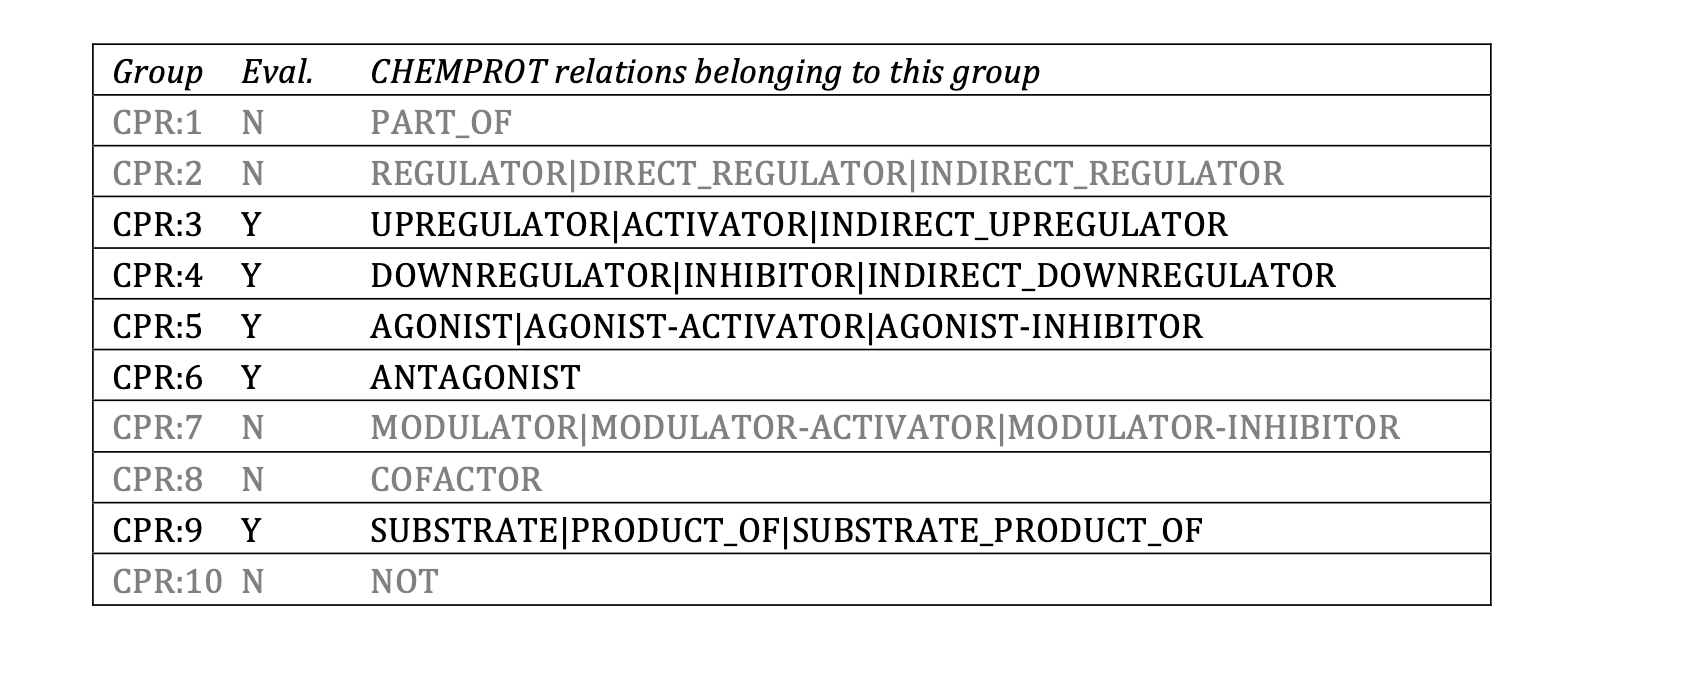

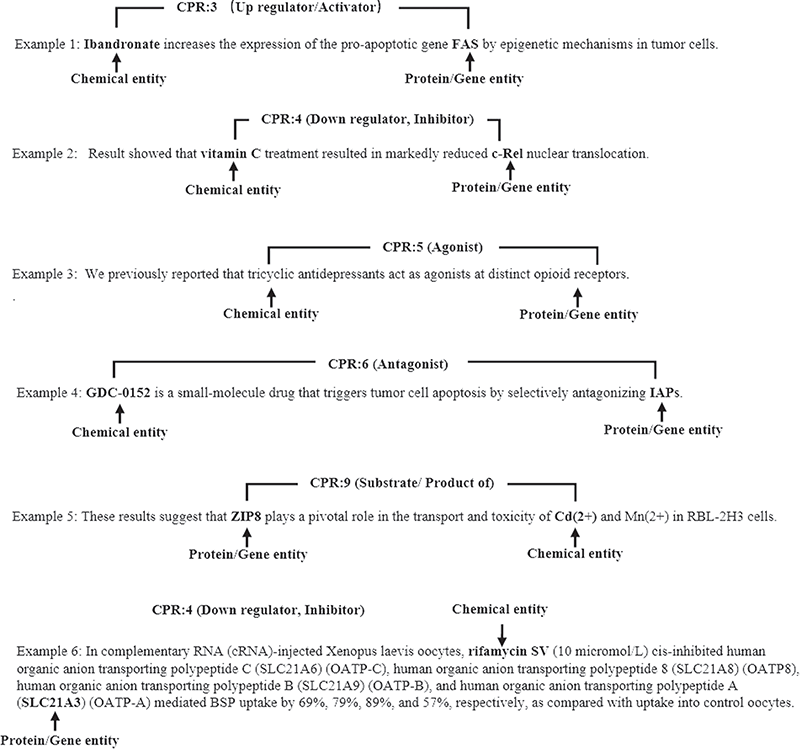

ChemProt RE works well with `ner_chemprot_clinical` find relationships between the following entities

`CHEMICAL`: Chemical entity mention type; 

`GENE-Y`: gene/protein mention type that can be normalized or associated to a biological database identifier; 

`GENE-N`: gene/protein mention type that cannot be normalized to a database identifier. 


In [39]:
ner_tagger = MedicalNerModel()\
    .pretrained("ner_chemprot_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")   

ner_converter = NerConverterInternal() \
    .setInputCols(["sentences", "tokens", "ner_tags"]) \
    .setOutputCol("ner_chunk")

chemprot_re_model = RelationExtractionModel()\
    .pretrained("re_chemprot_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunk", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\

chemprot_pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    ner_tagger,
    ner_converter,
    dependency_parser,
    chemprot_re_model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

chemprot_model = chemprot_pipeline.fit(empty_data)

ner_chemprot_clinical download started this may take some time.
Approximate size to download 15.3 MB
[OK!]
re_chemprot_clinical download started this may take some time.
Approximate size to download 5.9 MB
[OK!]


In [40]:
text='''
In this study, we examined the effects of mitiglinide on various cloned K(ATP) channels (Kir6.2/SUR1, Kir6.2/SUR2A, and Kir6.2/SUR2B) reconstituted in COS-1 cells, and compared them to another meglitinide-related compound, nateglinide. Patch-clamp analysis using inside-out recording configuration showed that mitiglinide inhibits the Kir6.2/SUR1 channel currents in a dose-dependent manner (IC50 value, 100 nM) but does not significantly inhibit either Kir6.2/SUR2A or Kir6.2/SUR2B channel currents even at high doses (more than 10 microM). Nateglinide inhibits Kir6.2/SUR1 and Kir6.2/SUR2B channels at 100 nM, and inhibits Kir6.2/SUR2A channels at high concentrations (1 microM). Binding experiments on mitiglinide, nateglinide, and repaglinide to SUR1 expressed in COS-1 cells revealed that they inhibit the binding of [3H]glibenclamide to SUR1 (IC50 values: mitiglinide, 280 nM; nateglinide, 8 microM; repaglinide, 1.6 microM), suggesting that they all share a glibenclamide binding site. The insulin responses to glucose, mitiglinide, tolbutamide, and glibenclamide in MIN6 cells after chronic mitiglinide, nateglinide, or repaglinide treatment were comparable to those after chronic tolbutamide and glibenclamide treatment. These results indicate that, similar to the sulfonylureas, mitiglinide is highly specific to the Kir6.2/SUR1 complex, i.e., the pancreatic beta-cell K(ATP) channel, and suggest that mitiglinide may be a clinically useful anti-diabetic drug.
'''
lmodel = LightPipeline(chemprot_model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df[rel_df.entity1!=rel_df.entity2]

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,CPR:2,CHEMICAL,43,53,mitiglinide,GENE-N,80,87,channels,0.6070414
1,CPR:2,GENE-N,80,87,channels,CHEMICAL,224,234,nateglinide,0.98933965
4,CPR:4,CHEMICAL,706,716,mitiglinide,GENE-Y,751,754,SUR1,0.7594982
6,CPR:2,CHEMICAL,719,729,nateglinide,GENE-Y,751,754,SUR1,0.9999553
7,CPR:2,CHEMICAL,736,746,repaglinide,GENE-Y,751,754,SUR1,0.9919803
8,CPR:2,CHEMICAL,823,839,[3H]glibenclamide,GENE-Y,844,847,SUR1,1.0
11,CPR:2,GENE-N,998,1004,insulin,CHEMICAL,1019,1025,glucose,0.59488183
12,CPR:2,GENE-N,998,1004,insulin,CHEMICAL,1028,1038,mitiglinide,0.5599123
13,CPR:3,GENE-N,998,1004,insulin,CHEMICAL,1041,1051,tolbutamide,0.98802537
14,CPR:3,GENE-N,998,1004,insulin,CHEMICAL,1058,1070,glibenclamide,0.98900056


# Train a Relation Extraction Model

In [41]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/i2b2_clinical_rel_dataset.csv

In [ ]:
# if you need to custoize the DL arcitecture (more layers, more features etc.)

from sparknlp_jsl.training import tf_graph

%tensorflow_version 1.x

tf_graph.build("relation_extraction", build_params={"input_dim": 6000, "output_dim": 3, 'batch_norm':1, "hidden_layers": [300, 200], "hidden_act": "relu", 'hidden_act_l2':1}, model_location=".", model_filename="re_with_BN")


In [43]:
tf_graph.print_model_params("relation_extraction")

relation_extraction parameters.
Parameter            Required   Default value        Description
hidden_layers        no         [200]                List of integers indicating the size of each hidden layer. For example: [100, 200, 300].
input_dim            yes        -                    Input dimension.
output_dim           yes        -                    Output dimension.
hidden_act           no         relu                 Activation function of hidden layers: relu, sigmoid, tanh or linear.
hidden_act_l2        no         0                    L2 regularization of hidden layer activations. Boolean (0 or 1).
hidden_weights_l2    no         0                    L2 regularization of hidden layer weights. Boolean (0 or 1).
batch_norm           no         0                    Batch normalization. Boolean (0 or 1).


In [44]:
data = spark.read.option("header","true").format("csv").load("i2b2_clinical_rel_dataset.csv")

data = data.select( 'sentence','firstCharEnt1','firstCharEnt2','lastCharEnt1','lastCharEnt2', "chunk1", "chunk2", "label1", "label2",'rel','dataset')

data.show(10)

# you only need these columns>> 'sentence','firstCharEnt1','firstCharEnt2','lastCharEnt1','lastCharEnt2', "chunk1", "chunk2", "label1", "label2",'rel'
# ('dataset' column is optional)

+--------------------+-------------+-------------+------------+------------+--------------------+--------------------+---------+---------+-----+-------+
|            sentence|firstCharEnt1|firstCharEnt2|lastCharEnt1|lastCharEnt2|              chunk1|              chunk2|   label1|   label2|  rel|dataset|
+--------------------+-------------+-------------+------------+------------+--------------------+--------------------+---------+---------+-----+-------+
|VITAL SIGNS - Tem...|           49|           75|          64|          84|    respiratory rate|          saturation|     test|     test|    O|   test|
|No lotions , crea...|            3|           34|           9|          42|             lotions|           incisions|treatment|  problem|TrNAP|   test|
|Because of expect...|           11|           58|          54|          68|expected long ter...|         a picc line|treatment|treatment|    O|  train|
|She states this l...|           16|           82|          31|          92|    li

In [45]:
data.groupby('dataset').count().show()

+-------+-----+
|dataset|count|
+-------+-----+
|  train|  350|
|   test|  650|
+-------+-----+



In [46]:
#Annotation structure
annotationType = T.StructType([
            T.StructField('annotatorType', T.StringType(), False),
            T.StructField('begin', T.IntegerType(), False),
            T.StructField('end', T.IntegerType(), False),
            T.StructField('result', T.StringType(), False),
            T.StructField('metadata', T.MapType(T.StringType(), T.StringType()), False),
            T.StructField('embeddings', T.ArrayType(T.FloatType()), False)
        ])

#UDF function to convert train data to names entitities

@F.udf(T.ArrayType(annotationType))
def createTrainAnnotations(begin1, end1, begin2, end2, chunk1, chunk2, label1, label2):
    
    entity1 = sparknlp.annotation.Annotation("chunk", begin1, end1, chunk1, {'entity': label1.upper(), 'sentence': '0'}, [])
    entity2 = sparknlp.annotation.Annotation("chunk", begin2, end2, chunk2, {'entity': label2.upper(), 'sentence': '0'}, [])    
        
    entity1.annotatorType = "chunk"
    entity2.annotatorType = "chunk"

    return [entity1, entity2]    

#list of valid relations
rels = ["TrIP", "TrAP", "TeCP", "TrNAP", "TrCP", "PIP", "TrWP", "TeRP"]

#a query to select list of valid relations
valid_rel_query = "(" + " OR ".join(["rel = '{}'".format(rel) for rel in rels]) + ")"

data = data\
  .withColumn("begin1i", F.expr("cast(firstCharEnt1 AS Int)"))\
  .withColumn("end1i", F.expr("cast(lastCharEnt1 AS Int)"))\
  .withColumn("begin2i", F.expr("cast(firstCharEnt2 AS Int)"))\
  .withColumn("end2i", F.expr("cast(lastCharEnt2 AS Int)"))\
  .where("begin1i IS NOT NULL")\
  .where("end1i IS NOT NULL")\
  .where("begin2i IS NOT NULL")\
  .where("end2i IS NOT NULL")\
  .where(valid_rel_query)\
  .withColumn(
      "train_ner_chunks", 
      createTrainAnnotations(
          "begin1i", "end1i", "begin2i", "end2i", "chunk1", "chunk2", "label1", "label2"
      ).alias("train_ner_chunks", metadata={'annotatorType': "chunk"}))
    

train_data = data.where("dataset='train'")
test_data = data.where("dataset='test'")

In [ ]:
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/generic_classifier_graph/RE_in1200D_out20.pb

In [48]:
documenter = DocumentAssembler()\
    .setInputCol("sentence")\
    .setOutputCol("sentences")

tokenizer = Tokenizer()\
    .setInputCols(["sentences"])\
    .setOutputCol("tokens")\

words_embedder = WordEmbeddingsModel()\
    .pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("embeddings")

pos_tagger = PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("pos_tags")
    
dependency_parser = DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentences", "pos_tags", "tokens"])\
    .setOutputCol("dependencies")

# set training params and upload model graph (see ../Healthcare/8.Generic_Classifier.ipynb)
reApproach = RelationExtractionApproach()\
    .setInputCols(["embeddings", "pos_tags", "train_ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setLabelColumn("rel")\
    .setEpochsNumber(70)\
    .setBatchSize(200)\
    .setDropout(0.5)\
    .setLearningRate(0.001)\
    .setModelFile("/content/RE_in1200D_out20.pb")\
    .setFixImbalance(True)\
    .setFromEntity("begin1i", "end1i", "label1")\
    .setToEntity("begin2i", "end2i", "label2")\
    .setOutputLogsPath('/content')

finisher = Finisher()\
    .setInputCols(["relations"])\
    .setOutputCols(["relations_out"])\
    .setCleanAnnotations(False)\
    .setValueSplitSymbol(",")\
    .setAnnotationSplitSymbol(",")\
    .setOutputAsArray(False)

train_pipeline = Pipeline(stages=[
    documenter, 
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    dependency_parser, 
    reApproach, 
    finisher
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]


In [49]:
%time rel_model = train_pipeline.fit(train_data)

CPU times: user 88.8 ms, sys: 13.4 ms, total: 102 ms
Wall time: 7.92 s


In [50]:
rel_model.stages

[DocumentAssembler_e7d166964c5b,
 REGEX_TOKENIZER_66b22e93ae7a,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 POS_6f55785005bf,
 dependency_d5a8da6c9093,
 RelationExtractionModel_382fd7b2c205,
 Finisher_eaa614bff544]

In [51]:
rel_model.stages[-2]

RelationExtractionModel_382fd7b2c205

In [52]:
rel_model.stages[-2].write().overwrite().save('custom_RE_model')

In [53]:
result = rel_model.transform(test_data)

In [54]:
recall = result\
  .groupBy("rel")\
  .agg(F.avg(F.expr("IF(rel = relations_out, 1, 0)")).alias("recall"))\
  .select(
      F.col("rel").alias("relation"), 
      F.format_number("recall", 2).alias("recall"))\
  .show()

performance  = result\
  .where("relations_out <> ''")\
  .groupBy("relations_out")\
  .agg(F.avg(F.expr("IF(rel = relations_out, 1, 0)")).alias("precision"))\
  .select(
      F.col("relations_out").alias("relation"), 
      F.format_number("precision", 2).alias("precision"))\
  .show()

+--------+------+
|relation|recall|
+--------+------+
|    TrIP|  0.18|
|    TrAP|  0.62|
|    TeCP|  0.20|
|   TrNAP|  0.11|
|    TrCP|  0.25|
|     PIP|  0.76|
|    TrWP|  0.00|
|    TeRP|  0.59|
+--------+------+

+--------+---------+
|relation|precision|
+--------+---------+
|    TrIP|     0.29|
|    TrAP|     0.70|
|    TeCP|     0.33|
|   TrNAP|     0.11|
|    TrCP|     0.23|
|     PIP|     0.82|
|    TrWP|     0.00|
|    TeRP|     0.83|
+--------+---------+



In [55]:
result_df = result.select(F.explode(F.arrays_zip('relations.result', 'relations.metadata')).alias("cols")) \
.select(F.expr("cols['0']").alias("relation"),
        F.expr("cols['1']['entity1']").alias("entity1"),
        F.expr("cols['1']['entity1_begin']").alias("entity1_begin"),
        F.expr("cols['1']['entity1_end']").alias("entity1_end"),
        F.expr("cols['1']['chunk1']").alias("chunk1"),
        F.expr("cols['1']['entity2']").alias("entity2"),
        F.expr("cols['1']['entity2_begin']").alias("entity2_begin"),
        F.expr("cols['1']['entity2_end']").alias("entity2_end"),
        F.expr("cols['1']['chunk2']").alias("chunk2"),
        F.expr("cols['1']['confidence']").alias("confidence")
        )

result_df.show(50, truncate=100)



+--------+---------+-------------+-----------+----------------------------------------------------------+-------+-------------+-----------+-----------------------------------------------------------+----------+
|relation|  entity1|entity1_begin|entity1_end|                                                    chunk1|entity2|entity2_begin|entity2_end|                                                     chunk2|confidence|
+--------+---------+-------------+-----------+----------------------------------------------------------+-------+-------------+-----------+-----------------------------------------------------------+----------+
|    TrAP|TREATMENT|            3|          9|                                                   lotions|PROBLEM|           34|         42|                                                  incisions|0.62519014|
|     PIP|  PROBLEM|          196|        239|              an inferior and right ventricular infarction|PROBLEM|          145|        176|                 

## Load trained model from disk

In [56]:
import pandas as pd

def get_relations_df (results, col='relations'):
  rel_pairs=[]
  for rel in results[0][col]:
      rel_pairs.append((
          rel.result, 
          rel.metadata['entity1'], 
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'], 
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'], 
          rel.metadata['confidence']
      ))

  rel_df = pd.DataFrame(rel_pairs, columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])

  return rel_df

In [57]:
documenter = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencer = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentences")

clinical_ner_tagger = MedicalNerModel()\
    .pretrained("ner_clinical",'en','clinical/models')\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

loaded_re_Model = RelationExtractionModel()\
    .load("custom_RE_model")\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"]) \
    .setOutputCol("relations")\
    .setRelationPairs(["problem-test", "problem-treatment"])\
    .setPredictionThreshold(0.9)\
    .setMaxSyntacticDistance(4)

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    clinical_ner_tagger,
    ner_chunker,
    dependency_parser,
    loaded_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


In [58]:
text ="""A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), 
one prior episode of HTG-induced pancreatitis three years prior to presentation,  associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection. She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely . 
She had close follow-up with endocrinology post discharge .
"""

re_model_light = LightPipeline(model)

annotations = re_model_light.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,TrAP,TREATMENT,507,517,amoxicillin,PROBLEM,523,551,a respiratory tract infection,0.9990169
1,TrAP,TREATMENT,577,585,glipizide,PROBLEM,611,614,T2DM,0.91866547
2,TrAP,TREATMENT,593,605,dapagliflozin,PROBLEM,611,614,T2DM,0.9849557
3,TrAP,TREATMENT,637,647,gemfibrozil,PROBLEM,653,655,HTG,0.9771778
4,TrAP,TREATMENT,1931,1945,an insulin drip,PROBLEM,1951,1955,euDKA,0.9017068


# End-to-end trained Models using BioBERT
#### Latest addition to Spark NLP for Heathcare - (Requires Spark NLP 2.7.3+ and Spark NLP JSL 2.7.3+)

These models are trained as end-to-end bert models using BioBERT and ported in to the Spark NLP ecosystem. 

They offer SOTA performance on most benchmark tasks and outperform our existing Relation Extraction Models.

## ADE ReDL

In [47]:
ner_tagger = MedicalNerModel.pretrained("ner_ade_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")  

ade_re_ner_chunk_filter = RENerChunksFilter() \
    .setInputCols(["ner_chunks", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
    .setMaxSyntacticDistance(10)\
    .setRelationPairs(["drug-ade, ade-drug"])

ade_re_model = RelationExtractionDLModel()\
    .pretrained('redl_ade_biobert', 'en', "clinical/models") \
    .setPredictionThreshold(0.5)\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")

ade_pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    ner_tagger,
    ner_chunker,
    dependency_parser,
    ade_re_ner_chunk_filter,
    ade_re_model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_model = ade_pipeline.fit(empty_data)

ner_ade_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
redl_ade_biobert download started this may take some time.
Approximate size to download 383.3 MB
[OK!]


In [48]:
text ="""A 44-year-old man taking naproxen for chronic low back pain and a 20-year-old woman on oxaprozin for rheumatoid arthritis presented with tense bullae and cutaneous fragility on the face and the back of the hands."""

ade_lmodel = LightPipeline(ade_model)
ade_results = ade_lmodel.fullAnnotate(text)

rel_df = get_relations_df (ade_results)

rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,1,DRUG,25,32,naproxen,ADE,137,148,tense bullae,0.9991972
1,1,DRUG,25,32,naproxen,ADE,154,210,cutaneous fragility on the face and the back o...,0.99912006
2,1,DRUG,87,95,oxaprozin,ADE,137,148,tense bullae,0.9993067
3,1,DRUG,87,95,oxaprozin,ADE,154,210,cutaneous fragility on the face and the back o...,0.99994886


## Clinical ReDL

In [59]:
clinical_ner_tagger = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

clinical_re_ner_chunk_filter = RENerChunksFilter() \
    .setInputCols(["ner_chunks", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
    .setMaxSyntacticDistance(4)\
    .setRelationPairs(["problem-test", "problem-treatment"])# we can set the possible relation pairs (if not set, all the relations will be calculated)
    
clinical_re_Model = RelationExtractionDLModel() \
    .pretrained('redl_clinical_biobert', "en", "clinical/models")\
    .setPredictionThreshold(0.9)\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    clinical_ner_tagger,
    ner_chunker,
    dependency_parser,
    clinical_re_ner_chunk_filter,
    clinical_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
redl_clinical_biobert download started this may take some time.
Approximate size to download 383.4 MB
[OK!]


In [60]:
text ="""A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), 
one prior episode of HTG-induced pancreatitis three years prior to presentation,  associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely . 
She had close follow-up with endocrinology post discharge .
"""
lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df = rel_df[(rel_df.relation!="O")]

rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,TrAP,TREATMENT,512,522,amoxicillin,PROBLEM,528,556,a respiratory tract infection,0.9980209
1,TrAP,TREATMENT,571,579,metformin,PROBLEM,617,620,T2DM,0.9975683
2,TrAP,TREATMENT,583,591,glipizide,PROBLEM,617,620,T2DM,0.99504143
3,TrAP,TREATMENT,599,611,dapagliflozin,PROBLEM,617,620,T2DM,0.997843
4,TrAP,TREATMENT,599,611,dapagliflozin,PROBLEM,659,661,HTG,0.9952559
5,TrAP,PROBLEM,617,620,T2DM,TREATMENT,626,637,atorvastatin,0.99499726
6,TrAP,PROBLEM,617,620,T2DM,TREATMENT,643,653,gemfibrozil,0.99362516
7,TrAP,TREATMENT,626,637,atorvastatin,PROBLEM,659,661,HTG,0.99163365
8,TrAP,TREATMENT,643,653,gemfibrozil,PROBLEM,659,661,HTG,0.9958056
9,TeRP,TEST,739,758,Physical examination,PROBLEM,796,810,dry oral mucosa,0.9966402


## Clinical Temporal Events ReDL

In [61]:
events_ner_tagger = MedicalNerModel.pretrained("ner_events_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")     

events_re_ner_chunk_filter = RENerChunksFilter() \
    .setInputCols(["ner_chunks", "dependencies"])\
    .setOutputCol("re_ner_chunks")
    
events_re_Model = RelationExtractionDLModel() \
    .pretrained('redl_temporal_events_biobert', "en", "clinical/models")\
    .setPredictionThreshold(0.5)\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    events_ner_tagger,
    ner_chunker,
    dependency_parser,
    events_re_ner_chunk_filter,
    events_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

ner_events_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
redl_temporal_events_biobert download started this may take some time.
Approximate size to download 383.4 MB
[OK!]


In [62]:
text ="She is diagnosed as cancer in 1991. Then she was admitted to Mayo Clinic in May 2000 and discharged in October 2001"

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df.confidence = rel_df.confidence.astype(float)

rel_df = rel_df[(rel_df.relation!="O")]

rel_df[(rel_df.relation!="O")&(rel_df.entity1!=rel_df.entity2)]


,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,OVERLAP,PROBLEM,20,25,cancer,DATE,30,33,1991,0.835316
1,AFTER,OCCURRENCE,49,56,admitted,CLINICAL_DEPT,61,71,Mayo Clinic,0.780135
2,OVERLAP,OCCURRENCE,49,56,admitted,DATE,76,83,May 2000,0.585613
4,OVERLAP,CLINICAL_DEPT,61,71,Mayo Clinic,DATE,76,83,May 2000,0.746398
5,BEFORE,CLINICAL_DEPT,61,71,Mayo Clinic,OCCURRENCE,89,98,discharged,0.612289
6,OVERLAP,CLINICAL_DEPT,61,71,Mayo Clinic,DATE,103,114,October 2001,0.727739


In [63]:
text ="""She is admitted to The John Hopkins Hospital 2 days ago with a history of gestational diabetes mellitus diagnosed.  
She was seen by the endocrinology service and she was discharged on 03/02/2018 on 40 units of insulin glargine, 
12 units of insulin lispro, and metformin 1000 mg two times a day. She had close follow-up with endocrinology post discharge. 
"""

annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df.confidence = rel_df.confidence.astype(float)

rel_df[(rel_df.relation!="O")]


,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,AFTER,OCCURRENCE,7,14,admitted,CLINICAL_DEPT,19,43,The John Hopkins Hospital,0.889128
1,BEFORE,OCCURRENCE,7,14,admitted,DATE,45,54,2 days ago,0.524205
2,BEFORE,OCCURRENCE,7,14,admitted,PROBLEM,74,102,gestational diabetes mellitus,0.780773
3,OVERLAP,CLINICAL_DEPT,19,43,The John Hopkins Hospital,DATE,45,54,2 days ago,0.752731
4,BEFORE,CLINICAL_DEPT,19,43,The John Hopkins Hospital,PROBLEM,74,102,gestational diabetes mellitus,0.532711
5,BEFORE,CLINICAL_DEPT,133,157,the endocrinology service,OCCURRENCE,171,180,discharged,0.502746
6,OVERLAP,CLINICAL_DEPT,133,157,the endocrinology service,DATE,185,194,03/02/2018,0.651971
7,OVERLAP,CLINICAL_DEPT,133,157,the endocrinology service,TREATMENT,211,226,insulin glargine,0.831935
8,OVERLAP,CLINICAL_DEPT,133,157,the endocrinology service,TREATMENT,242,255,insulin lispro,0.750016
9,OVERLAP,CLINICAL_DEPT,133,157,the endocrinology service,TREATMENT,262,270,metformin,0.959357


## Human Phenotype - Gene ReDL

In [64]:
pgr_ner_tagger = MedicalNerModel.pretrained("ner_human_phenotype_gene_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

pgr_re_ner_chunk_filter = RENerChunksFilter() \
    .setInputCols(["ner_chunks", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
    .setMaxSyntacticDistance(4)
    
pgr_re_Model = RelationExtractionDLModel() \
    .pretrained('redl_human_phenotype_gene_biobert', "en", "clinical/models")\
    .setPredictionThreshold(0.5)\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    pgr_ner_tagger,
    ner_chunker,
    dependency_parser,
    pgr_re_ner_chunk_filter,
    pgr_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

ner_human_phenotype_gene_clinical download started this may take some time.
Approximate size to download 14 MB
[OK!]
redl_human_phenotype_gene_biobert download started this may take some time.
Approximate size to download 383.4 MB
[OK!]


In [65]:
text = "She has a retinal degeneration, hearing loss and renal failure, short stature, \
Mutations in the SH3PXD2B gene coding for the Tks4 protein are responsible for the autosomal recessive."

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df = rel_df[(rel_df.relation!=0)]

rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,0,HP,10,29,retinal degeneration,HP,32,43,hearing loss,0.9282822
1,0,HP,10,29,retinal degeneration,HP,49,61,renal failure,0.9465185
2,0,HP,10,29,retinal degeneration,HP,162,180,autosomal recessive,0.5842949
3,0,HP,32,43,hearing loss,HP,49,61,renal failure,0.9649007
4,0,HP,32,43,hearing loss,HP,64,76,short stature,0.8631831
5,1,HP,32,43,hearing loss,GENE,96,103,SH3PXD2B,0.92471504
6,1,HP,32,43,hearing loss,HP,162,180,autosomal recessive,0.89216185
7,0,HP,49,61,renal failure,HP,64,76,short stature,0.81797004
8,0,HP,49,61,renal failure,GENE,96,103,SH3PXD2B,0.52181184
9,1,HP,49,61,renal failure,HP,162,180,autosomal recessive,0.72006804


## Drug-Drug Interaction ReDL

In [66]:
ddi_ner_tagger = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")   

ddi_re_ner_chunk_filter = RENerChunksFilter() \
    .setInputCols(["ner_chunks", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
    .setMaxSyntacticDistance(4)
    
ddi_re_Model = RelationExtractionDLModel() \
    .pretrained('redl_drug_drug_interaction_biobert', "en", "clinical/models")\
    .setPredictionThreshold(0.9)\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    ddi_ner_tagger,
    ner_chunker,
    dependency_parser,
    ddi_re_ner_chunk_filter,
    ddi_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
redl_drug_drug_interaction_biobert download started this may take some time.
Approximate size to download 383.4 MB
[OK!]


In [67]:
text='When carbamazepine is withdrawn from the combination therapy, aripiprazole dose should then be reduced. \
If additional adrenergic drugs are to be administered by any route, \
they should be used with caution because the pharmacologically predictable sympathetic effects of Metformin may be potentiated'

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,DDI-false,DRUG,5,17,carbamazepine,DRUG,62,73,aripiprazole,0.94803786


## Chemical–Protein Interactions (ChemProt) ReDL

In [11]:
chemprot_ner_tagger = MedicalNerModel.pretrained("ner_chemprot_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")   

chemprot_re_ner_chunk_filter = RENerChunksFilter() \
    .setInputCols(["ner_chunks", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
    .setMaxSyntacticDistance(4)
    
chemprot_re_Model = RelationExtractionDLModel() \
    .pretrained('redl_chemprot_biobert', "en", "clinical/models")\
    .setPredictionThreshold(0.9)\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    chemprot_ner_tagger,
    ner_chunker,
    dependency_parser,
    chemprot_re_ner_chunk_filter,
    chemprot_re_Model
])


empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

ner_chemprot_clinical download started this may take some time.
Approximate size to download 15.3 MB
[OK!]
redl_chemprot_biobert download started this may take some time.
Approximate size to download 383.4 MB
[OK!]


In [12]:
text='''
In this study, we examined the effects of mitiglinide on various cloned K(ATP) channels (Kir6.2/SUR1, Kir6.2/SUR2A, and Kir6.2/SUR2B) reconstituted in COS-1 cells, and compared them to another meglitinide-related compound, nateglinide. Patch-clamp analysis using inside-out recording configuration showed that mitiglinide inhibits the Kir6.2/SUR1 channel currents in a dose-dependent manner (IC50 value, 100 nM) but does not significantly inhibit either Kir6.2/SUR2A or Kir6.2/SUR2B channel currents even at high doses (more than 10 microM). Nateglinide inhibits Kir6.2/SUR1 and Kir6.2/SUR2B channels at 100 nM, and inhibits Kir6.2/SUR2A channels at high concentrations (1 microM). Binding experiments on mitiglinide, nateglinide, and repaglinide to SUR1 expressed in COS-1 cells revealed that they inhibit the binding of [3H]glibenclamide to SUR1 (IC50 values: mitiglinide, 280 nM; nateglinide, 8 microM; repaglinide, 1.6 microM), suggesting that they all share a glibenclamide binding site. The insulin responses to glucose, mitiglinide, tolbutamide, and glibenclamide in MIN6 cells after chronic mitiglinide, nateglinide, or repaglinide treatment were comparable to those after chronic tolbutamide and glibenclamide treatment. These results indicate that, similar to the sulfonylureas, mitiglinide is highly specific to the Kir6.2/SUR1 complex, i.e., the pancreatic beta-cell K(ATP) channel, and suggest that mitiglinide may be a clinically useful anti-diabetic drug.
'''
lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df[rel_df.entity1!=rel_df.entity2]

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,CPR:2,CHEMICAL,43,53,mitiglinide,GENE-N,80,87,channels,0.9980313
1,CPR:2,GENE-N,80,87,channels,CHEMICAL,224,234,nateglinide,0.9947483
4,CPR:2,CHEMICAL,706,716,mitiglinide,GENE-Y,751,754,SUR1,0.9992416
6,CPR:2,CHEMICAL,719,729,nateglinide,GENE-Y,751,754,SUR1,0.99792683
7,CPR:2,CHEMICAL,736,746,repaglinide,GENE-Y,751,754,SUR1,0.99888176
8,CPR:2,CHEMICAL,823,839,[3H]glibenclamide,GENE-Y,844,847,SUR1,0.99731845
11,CPR:2,GENE-N,998,1004,insulin,CHEMICAL,1019,1025,glucose,0.9789721
12,CPR:2,GENE-N,998,1004,insulin,CHEMICAL,1028,1038,mitiglinide,0.9673025
13,CPR:2,GENE-N,998,1004,insulin,CHEMICAL,1041,1051,tolbutamide,0.9895331
14,CPR:2,GENE-N,998,1004,insulin,CHEMICAL,1058,1070,glibenclamide,0.98970526
